<a href="https://colab.research.google.com/github/t2tato01/amazon_fine_food_analysis_group/blob/main/amazon_fine_food_analysis_tomoko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Amazon Fine Food Reviews Analysis

This notebook implements the analysis pipeline described in the project specification.  It will:

1. Download the Amazon Fine Food Reviews dataset using **kagglehub**.
2. Select three subsets of reviews based on helpfulness metrics (L1, L2, L3).
3. Compute descriptive statistics for token and character counts.
4. Perform sentiment analysis using SentiStrength (with a fallback heuristic).
5. Discretise review timestamps into ten bins and plot sentiment distributions.
6. Compute Pearson correlations between sentiment/non‑stopword proportions/token counts and user ratings.
7. Detect incomplete sentences using part‑of‑speech tagging and analyse their relationship to sentiment.
8. Calculate readability metrics (Gunning Fog and ForeCast) and test correlations with ratings and helpfulness.
9. Evaluate how well the provided summaries match the full review text using fuzzy matching, and compare them to summaries generated with LexRank and a simple frequency‑based method.

Run each cell in order.  The notebook will write results to local files and display plots inline.


In [ ]:

# Install necessary libraries
!pip install kagglehub sentistrength fuzzywuzzy python-Levenshtein nltk gensim matplotlib scipy --quiet
# Download sentiment data for SentiStrength (optional but recommended)
!python -m sentistrength.download --quiet || echo "SentiStrength data download skipped"
# Uninstall any existing gensim version first (optional but safest)



import nltk
from nltk.corpus import opinion_lexicon

# Download NLTK resources (punkt, stopwords) if not already present
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('opinion_lexicon')


/usr/bin/python3: No module named sentistrength.download
SentiStrength data download skipped


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.


True

In [ ]:

import os
import kagglehub
import pandas as pd

# Download the dataset (this will save files under ~/.kagglehub)
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")
print("Path to dataset files:", path)

# Build the CSV path
csv_path = os.path.join(path, "Reviews.csv")

# Load the dataset
# Note: 'on_bad_lines='skip'' will skip malformed rows
# and the python engine is used for robust parsing

df = pd.read_csv(csv_path, on_bad_lines='skip', engine='python')
print("Loaded", len(df), "rows.")
# Display first few rows
df.head()


Using Colab cache for faster access to the 'amazon-fine-food-reviews' dataset.
Path to dataset files: /kaggle/input/amazon-fine-food-reviews
Loaded 568454 rows.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [36]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz

# Prepare stopword set
try:
    stopwords_set = set(stopwords.words("english"))
except Exception:
    stopwords_set = {"the", "a", "an", "and", "or", "is", "to", "of", "in", "that"}

def tokenize(text):
    """Tokenize text using NLTK if available, otherwise split on whitespace."""
    try:
        return nltk.word_tokenize(text)
    except Exception:
        return text.split()

def non_stopword_proportion(tokens, stopwords_set_override=None):
    """Return the proportion of tokens that are not stopwords."""
    if not tokens:
        return float("nan")
    if stopwords_set_override is None:
        sw = stopwords_set
    else:
        sw = stopwords_set_override
    non_special = []
    for t in tokens:
        has_alnum = False
        for c in t:
            if c.isalnum():
                has_alnum = True
                break
        if has_alnum:
            non_special.append(t)
    non_stop = []
    for t in non_special:
        if t.lower() not in sw:
            non_stop.append(t)
    if not non_special:
        return float("nan")
    return float(len(non_stop)) / float(len(non_special))

def select_review_subsets(df, n=1000):
    """
    Identify three disjoint subsets of reviews:
      - L1: top n reviews by HelpfulnessDenominator (most users)
      - L2: bottom n reviews by HelpfulnessDenominator (fewest users)
      - L3: top n reviews by HelpfulnessNumerator (most users who found it helpful)

    Each review appears in at most one subset.

    Parameters:
        df (pd.DataFrame): The full dataset.
        n (int): Number of reviews to select for each subset.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: DataFrames for L1, L2, and L3.
    """
    # Make a copy and fill missing values with zero
    df_clean = df.copy()
    df_clean["HelpfulnessNumerator"] = df_clean["HelpfulnessNumerator"].fillna(0)
    df_clean["HelpfulnessDenominator"] = df_clean["HelpfulnessDenominator"].fillna(0)

    # Select L1: top by denominator
    l1 = df_clean.sort_values("HelpfulnessDenominator", ascending=False).head(n).copy()
    l1["Subset"] = "L1"

    # Remove L1 rows to avoid overlap with other sets
    remaining = df_clean.drop(l1.index)

    # Select L2: bottom by denominator (including zeros)
    l2 = remaining.sort_values("HelpfulnessDenominator", ascending=True).head(n).copy()
    l2["Subset"] = "L2"

    # Remove L2 rows
    remaining = remaining.drop(l2.index)

    # Select L3: top by numerator from remaining
    l3 = remaining.sort_values("HelpfulnessNumerator", ascending=False).head(n).copy()
    l3["Subset"] = "L3"

    return l1, l2, l3


def compute_text_statistics(df):
    """
    Compute per-review statistics:
      - number of tokens,
      - number of characters,
      - proportion of tokens that are NOT stopwords or special-character tokens.

    A token is considered a "special character" token if, after stripping
    punctuation, it contains no letters or digits. Such tokens are excluded
    from the proportion calculation.

    Parameters:
        df (pd.DataFrame): DataFrame with a "Text" column.

    Returns:
        pd.DataFrame: A copy of the input DataFrame with three new columns:
                      "num_tokens", "num_chars", and "prop_non_stopwords".
    """
    num_tokens = []
    num_chars = []
    prop_non_stop = []

    for text in df["Text"].astype(str):
        # Tokenize the text
        raw_tokens = tokenize(text)
        clean_tokens = []
        for tok in raw_tokens:
            # Strip leading/trailing punctuation
            stripped = tok.strip(r'''!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~''')
            # Keep token if it contains any alphanumeric character
            has_alnum = False
            for ch in stripped:
                if ch.isalnum():
                    has_alnum = True
                    break
            if has_alnum:
                clean_tokens.append(stripped.lower())

        # Count total tokens (excluding special-character-only tokens)
        num_tokens.append(len(clean_tokens))
        # Count characters in the original text (including punctuation and spaces)
        num_chars.append(len(text))

        # Compute non-stopword proportion
        if clean_tokens:
            non_stop_count = 0
            for t in clean_tokens:
                if t not in stopwords_set:
                    non_stop_count += 1
            proportion = float(non_stop_count) / float(len(clean_tokens))
        else:
            proportion = float("nan")
        prop_non_stop.append(proportion)

    # Create a new DataFrame with added columns
    new_df = df.copy()
    new_df["num_tokens"] = num_tokens
    new_df["num_chars"] = num_chars
    new_df["prop_non_stopwords"] = prop_non_stop

    return new_df


def summarise_statistics(df, label):
    """Return summary statistics for text metrics in a tidy DataFrame."""
    metrics = ["num_tokens", "num_chars", "prop_non_stopwords"]
    rows = []
    for m in metrics:
        series = df[m].dropna()
        row = {
            "subset": label,
            "metric": m,
            "mean": series.mean(),
            "std": series.std(ddof=1),
            "min": series.min(),
            "max": series.max(),
        }
        rows.append(row)
    return pd.DataFrame(rows)

# Attempt to load SentiStrength
# If it fails, sentiment estimation will fall back to a simple heuristic.
try:
    from sentistrength import SentimentStrength
    ss = SentimentStrength(lang="en")
except Exception:
    ss = None

def estimate_sentiment(text):
    """
    Compute sentiment using SentiStrength if available, otherwise a simple heuristic.
    Positive sentiment > 0, negative sentiment < 0, neutral sentiment = 0.
    """
    if ss is not None:
        try:
            pos, neg = ss.get_scores(text)
            # SentiStrength returns positive and negative scores; summing them yields overall sentiment
            return float(pos + neg)
        except Exception:
            pass
    # Fallback heuristic: count positive minus negative words
    positive_words = list(opinion_lexicon.positive())
    negative_words = list(opinion_lexicon.negative())

    words = tokenize(text.lower())
    pos_count = 0
    neg_count = 0
    for w in words:
        if w in positive_words:
            pos_count += 1
        if w in negative_words:
            neg_count += 1
    return float(pos_count - neg_count)

def discretise_time(df, bins=10):
    """
    Discretise the Unix timestamps into a specified number of bins.
    Adds a new column "time_bin" with integer bin labels.
    """
    timestamps = pd.to_datetime(df["Time"], unit="s")
    new_df = df.copy()
    # Create bins spanning the entire time range, labelled 0 .. bins-1
    new_df["time_bin"] = pd.cut(timestamps, bins=bins, labels=False, include_lowest=True)
    return new_df

def plot_sentiment_distribution(df, label):
    """
    Plot positive/neutral/negative sentiment proportions over time bins and
    display average sentiment per bin in the console.

    Parameters:
        df (pd.DataFrame): A DataFrame with columns "Text" and "Time".
        label (str): A label for the subset being plotted (e.g., "L1").
    """
    # Copy data to avoid mutating original DataFrame
    temp_df = df.copy()

    # Compute sentiment score for each review
    temp_df["sentiment"] = temp_df["Text"].astype(str).apply(estimate_sentiment)

    # Discretise the time into 10 bins
    temp_df = discretise_time(temp_df, bins=10)

    # Categorise each review by sentiment sign
    categories = []
    for s in temp_df["sentiment"]:
        if s > 0:
            categories.append("positive")
        elif s < 0:
            categories.append("negative")
        else:
            categories.append("neutral")
    temp_df["category"] = categories

    # Compute the average sentiment for each time bin and show it
    avg_sentiment = temp_df.groupby("time_bin")["sentiment"].mean()
    print("Average sentiment per time bin for {}:".format(label))
    print(avg_sentiment)

    # Compute counts of each sentiment category per time bin
    counts = temp_df.groupby(["time_bin", "category"]).size().unstack(fill_value=0)

    # Convert counts to proportions per time bin
    proportions = counts.div(counts.sum(axis=1), axis=0)

    # Plot the proportions
    plt.figure(figsize=(8, 5))
    for cat in ["positive", "neutral", "negative"]:
        if cat in proportions:
            plt.plot(proportions.index, proportions[cat], label=cat)
    plt.title("Sentiment distribution over time ({})".format(label))
    plt.xlabel("Time bin")
    plt.ylabel("Proportion of reviews")
    plt.legend()
    plt.show()


def compute_correlations(df, label):
    """
    Compute Pearson correlations between:
      1. Overall sentiment (from SentiStrength) vs. user rating (Score)
      2. Proportion of non-stopword tokens vs. user rating (Score)
      3. Number of tokens vs. user rating (Score)

    Parameters:
        df (pd.DataFrame): The subset DataFrame (e.g., L1, L2, or L3) with a 'Text' column.
        label (str): A label identifying the subset (e.g., "L1").

    Returns:
        pd.DataFrame: A tidy DataFrame with correlation coefficients and p-values.
    """
    temp_df = df.copy()

    # Compute overall sentiment using SentiStrength (or fallback) on the fly
    temp_df["sentiment"] = temp_df["Text"].astype(str).apply(estimate_sentiment)

    correlations = []
    # Define the pairs of variables to correlate with Score
    pairs = [("sentiment", "Score"),
             ("prop_non_stopwords", "Score"),
             ("num_tokens", "Score")]

    for x, y in pairs:
        sub = temp_df[[x, y]].dropna()
        if len(sub) < 2:
            # Not enough data points to compute correlation
            continue
        corr, pval = pearsonr(sub[x], sub[y])
        correlations.append({
            "subset": label,
            "variable": "{} vs {}".format(x, y),
            "correlation": corr,
            "pvalue": pval,
        })

    return pd.DataFrame(correlations)


def is_incomplete_sentence(sentence):
    """
    Detect if a sentence is incomplete.
    A sentence is considered incomplete if it lacks a likely subject or verb,
    or if it begins with a subordinating conjunction and does not contain a main clause.
    """
    words = tokenize(sentence)
    if not words:
        return False

    # Define common subordinating conjunctions that often start fragments
    subordinators = {"because", "although", "since", "if", "when", "while",
                     "though", "unless", "whereas", "as", "once", "after"}

    first_word_lower = words[0].lower()
    ends_with_clause_sep = any(punct in sentence for punct in [",", ";"])

    try:
        tags = nltk.pos_tag(words)

        # Flags for subject and verb detection
        has_verb = any(tag.startswith("VB") for _, tag in tags)
        has_subject = any(tag.startswith(("NN", "PRP", "DT")) for _, tag in tags)

        # Check if the sentence starts with a subordinating conjunction
        starts_with_subordinator = first_word_lower in subordinators

        # A sentence lacking subject or verb is incomplete
        if not (has_subject and has_verb):
            return True

        # If it starts with a subordinating conjunction and there's no clause separator,
        # it's likely a fragment (e.g. "Because the product was expensive")
        if starts_with_subordinator and not ends_with_clause_sep:
            return True

        # Otherwise, treat as complete
        return False

    except Exception:
        # Fallback: check for common verbs; if none, mark incomplete
        common_verbs = {"is", "are", "was", "were", "be", "have", "has",
                        "do", "did", "make", "go", "get", "take", "see"}
        for w in words:
            if w.lower() in common_verbs:
                return False
        # If it begins with a subordinating conjunction and lacks punctuation,
        # mark as incomplete in fallback as well
        if first_word_lower in subordinators and not ends_with_clause_sep:
            return True
        # Otherwise, mark as incomplete
        return True
def analyse_incomplete_sentences(df, label):
    """
    Analyse the prevalence of incomplete sentences by sentiment category.
    Returns the proportion of reviews with incomplete sentences per category.
    """
    temp_df = df.copy()
    temp_df["sentiment"] = temp_df["Text"].astype(str).apply(estimate_sentiment)

    # Map sentiment values to categories
    categories = []
    for s in temp_df["sentiment"]:
        if s > 0:
            categories.append("positive")
        elif s < 0:
            categories.append("negative")
        else:
            categories.append("neutral")
    temp_df["category"] = categories

    # Determine if each review has at least one incomplete sentence
    incomplete_flags = []
    for text in temp_df["Text"].astype(str):
        try:
            sentences = nltk.sent_tokenize(text)
        except Exception:
            sentences = [s.strip() for s in text.split(".") if s.strip()]
        has_incomplete = False
        for s in sentences:
            if is_incomplete_sentence(s):  # uses the new advanced check
                has_incomplete = True
                break
        incomplete_flags.append(has_incomplete)
    temp_df["incomplete"] = incomplete_flags

    # Compute the proportion of incomplete reviews per sentiment category
    proportions = (
        temp_df.groupby("category")["incomplete"].mean().reset_index(name="proportion_incomplete")
    )
    proportions["subset"] = label
    return proportions

def count_syllables(word):
    """Estimate the number of syllables in a word."""
    word = word.lower()
    vowels = "aeiouy"
    count = 0
    prev_char_vowel = False
    for c in word:
        is_vowel = (c in vowels)
        if is_vowel and not prev_char_vowel:
            count += 1
        prev_char_vowel = is_vowel
    if word.endswith("e") and count > 1:
        count -= 1
    if count < 1:
        count = 1
    return count

def gunning_fog_index(num_sentences, num_words, num_complex):
    """Calculate the Gunning Fog index."""
    if num_sentences == 0 or num_words == 0:
        return float("nan")
    return 0.4 * ((float(num_words) / float(num_sentences)) +
                  100.0 * (float(num_complex) / float(num_words)))

def forecast_formula(num_mono, num_words):
    """Calculate the ForeCast readability index."""
    if num_words == 0:
        return float("nan")
    return 20.0 - (float(num_mono) / float(num_words))

def compute_readability_scores(df):
    """Compute Gunning Fog and ForeCast scores for each review."""
    gf_scores = []
    fc_scores = []
    for text in df["Text"].astype(str):
        try:
            sentences = nltk.sent_tokenize(text)
        except Exception:
            sentences = [s.strip() for s in text.split(".") if s.strip()]
        words = tokenize(text)
        if sentences:
            num_sent = len(sentences)
        else:
            num_sent = 1
        num_words = len(words)
        num_complex = 0
        num_mono = 0
        for w in words:
            syll = count_syllables(w)
            if syll >= 3:
                num_complex += 1
            if syll == 1:
                num_mono += 1
        gf_scores.append(gunning_fog_index(num_sent, num_words, num_complex))
        fc_scores.append(forecast_formula(num_mono, num_words))
    new_df = df.copy()
    new_df["gunning_fog"] = gf_scores
    new_df["forecast"] = fc_scores
    return new_df

def compute_correlations(df, label):
    """
    Compute Pearson correlations between:
      1. Overall sentiment (from SentiStrength) vs. user rating (Score)
      2. Proportion of non-stopword tokens vs. user rating (Score)
      3. Number of tokens vs. user rating (Score)

    Skips pairs where either variable is constant (zero variance), since
    the correlation is undefined in that case.
    """
    temp_df = df.copy()
    temp_df["sentiment"] = temp_df["Text"].astype(str).apply(estimate_sentiment)
    results = []

    pairs = [("sentiment", "Score"),
             ("prop_non_stopwords", "Score"),
             ("num_tokens", "Score")]

    for x, y in pairs:
        sub = temp_df[[x, y]].dropna()
        if len(sub) < 2:
            continue
        # Skip if either series is constant
        if sub[x].nunique() <= 1 or sub[y].nunique() <= 1:
            continue
        corr, pval = pearsonr(sub[x], sub[y])
        results.append({
            "subset": label,
            "variable": f"{x} vs {y}",
            "correlation": corr,
            "pvalue": pval,
        })
    return pd.DataFrame(results)

def readability_correlations(df, label):
    """
    Compute correlations between readability scores and ratings/helpfulness.
    Skips pairs where either series is constant (zero variance).
    """
    variables = ["gunning_fog", "forecast"]
    targets = ["Score", "HelpfulnessNumerator", "HelpfulnessDenominator"]
    rows = []
    for var in variables:
        for target in targets:
            sub = df[[var, target]].dropna()
            if len(sub) < 2:
                continue
            # Skip if either series is constant
            if sub[var].nunique() <= 1 or sub[target].nunique() <= 1:
                continue
            corr, pval = pearsonr(sub[var], sub[target])
            rows.append({
                "subset": label,
                "variable": f"{var} vs {target}",
                "correlation": corr,
                "pvalue": pval,
            })
    return pd.DataFrame(rows)


def frequency_based_summarise(text, word_count=6):
    """Generate a summary by selecting the most frequent non-stopwords."""
    tokens = []
    for t in tokenize(text):
        if t.isalpha():
            tokens.append(t.lower())
    if not tokens:
        return ""
    filtered = []
    for t in tokens:
        if t not in stopwords_set:
            filtered.append(t)
    if not filtered:
        filtered = tokens
    freq = {}
    for t in filtered:
        freq[t] = freq.get(t, 0) + 1
    sorted_tokens = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    top_words = []
    for w, _ in sorted_tokens[:word_count]:
        top_words.append(w)
    return " ".join(top_words)

from fuzzywuzzy import fuzz

def summary_extractive_check(df, label, threshold=80):
    """
    Evaluate how extractive the provided summaries are by comparing each
    summary to its full review using fuzzy partial matching.

    Parameters:
        df (pd.DataFrame): A DataFrame with 'Summary' and 'Text' columns.
        label (str): Identifier for the subset (e.g. "L1").
        threshold (int): A score (0–100) above which the summary is
                         considered extractive.

    Returns:
        pd.DataFrame: Contains the subset label, mean overlap score,
                      and proportion of summaries that meet the threshold.
    """
    overlaps = []
    extractive_flags = []

    for _, row in df.iterrows():
        summary = str(row["Summary"])
        text = str(row["Text"])
        if not summary or not text:
            continue
        # Partial ratio finds the best matching substring of 'text' to 'summary'
        overlap_score = fuzz.partial_ratio(summary, text)
        overlaps.append(overlap_score)
        extractive_flags.append(overlap_score >= threshold)

    if overlaps:
        mean_overlap = sum(overlaps) / len(overlaps)
        proportion_extractive = sum(extractive_flags) / len(extractive_flags)
    else:
        mean_overlap = float("nan")
        proportion_extractive = float("nan")

    return pd.DataFrame([{
        "subset": label,
        "mean_overlap": mean_overlap,
        "proportion_extractive": proportion_extractive
    }])

from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from fuzzywuzzy import fuzz
import nltk

def gensim_tfidf_summary(text, word_count=6):
    """
    Generate a short summary by selecting the sentence with the highest
    summed TF-IDF weight using Gensim's corpus tools.
    """
    # Split the text into sentences
    try:
        sentences = nltk.sent_tokenize(text)
    except Exception:
        sentences = [s.strip() for s in text.split(".") if s.strip()]

    if not sentences:
        return ""

    # Tokenize and clean each sentence
    tokenized_sentences = []
    for sent in sentences:
        tokens = [token.lower() for token in tokenize(sent) if token.isalpha() and token.lower() not in stopwords_set]
        tokenized_sentences.append(tokens)

    # Build a dictionary and corpus
    dictionary = Dictionary(tokenized_sentences)
    corpus = [dictionary.doc2bow(sentence) for sentence in tokenized_sentences]

    # Train a TF-IDF model on the corpus
    tfidf = TfidfModel(corpus)

    # Score each sentence by summing its TF-IDF weights
    sentence_scores = []
    for bow in corpus:
        tfidf_weights = tfidf[bow]
        score = sum(weight for _, weight in tfidf_weights)
        sentence_scores.append(score)

    # Identify the sentence with the highest score
    best_idx = int(np.argmax(sentence_scores))
    best_sentence = sentences[best_idx]

    # Return the first 'word_count' words of the selected sentence
    return " ".join(tokenize(best_sentence)[:word_count])

def lexrank_summary_overlap(df, label, word_count=6):
    """
    Generate a summary for each review using a Gensim TF-IDF based approach
    and measure its similarity to the provided summary.

    Parameters:
        df (pd.DataFrame): DataFrame with 'Summary' and 'Text' columns.
        label (str): Identifier for the subset (e.g., "L1").
        word_count (int): Number of words to include from the generated summary.

    Returns:
        pd.DataFrame: Contains the subset label and the average fuzzy
                      overlap score between generated and provided summaries.
    """
    overlaps = []
    for _, row in df.iterrows():
        summary = str(row["Summary"])
        text = str(row["Text"])
        if not summary or not text:
            continue
        generated = gensim_tfidf_summary(text, word_count)
        overlaps.append(fuzz.partial_ratio(summary, generated))

    if overlaps:
        mean_overlap = sum(overlaps) / len(overlaps)
    else:
        mean_overlap = float("nan")

    return pd.DataFrame([{
        "subset": label,
        "gensim_tfidf_vs_original_overlap": mean_overlap
    }])

def alt_summary_overlap(df, label, word_count=6):
    """
    Generate a summary with an alternative method (here: frequency-based)
    and measure its similarity to the provided summary.

    Parameters:
        df (pd.DataFrame): A DataFrame with 'Summary' and 'Text' columns.
        label (str): Identifier for the subset (e.g. "L1").
        word_count (int): Number of words in the generated summary.

    Returns:
        pd.DataFrame: Contains the subset label and the average fuzzy
                      overlap score between the alternative and provided summaries.
    """
    overlaps = []

    for _, row in df.iterrows():
        summary = str(row["Summary"])
        text = str(row["Text"])
        if not summary or not text:
            continue

        generated = frequency_based_summarise(text, word_count)
        overlaps.append(fuzz.partial_ratio(summary, generated))

        # Note: frequency_based_summarise is defined earlier in your script.

    if overlaps:
        mean_overlap = sum(overlaps) / len(overlaps)
    else:
        mean_overlap = float("nan")

    return pd.DataFrame([{
        "subset": label,
        "alt_vs_original_overlap": mean_overlap
    }])

In [ ]:
# Task 1:
# Select subsets L1, L2, L3
l1, l2, l3 = select_review_subsets(df, n=1000)
print(f"L1: {len(l1)} reviews, L2: {len(l2)} reviews, L3: {len(l3)} reviews")

# Task 2:
# Compute text statistics
l1_stats = compute_text_statistics(l1)
l2_stats = compute_text_statistics(l2)
l3_stats = compute_text_statistics(l3)

# Summarise statistics
stats_summary = pd.concat([
    summarise_statistics(l1_stats, "L1"),
    summarise_statistics(l2_stats, "L2"),
    summarise_statistics(l3_stats, "L3"),
], ignore_index=True)

stats_summary


L1: 1000 reviews, L2: 1000 reviews, L3: 1000 reviews


,subset,metric,mean,std,min,max
0,L1,num_tokens,255.278000,231.451923,10.000000,1818.000000
1,L1,num_chars,1433.565000,1317.616613,57.000000,9754.000000
2,L1,prop_non_stopwords,0.521543,0.062205,0.263158,0.930233
3,L2,num_tokens,61.498000,46.366473,14.000000,357.000000
4,L2,num_chars,331.443000,254.934494,57.000000,1934.000000
5,L2,prop_non_stopwords,0.501253,0.069819,0.250000,0.764706
6,L3,num_tokens,193.970000,163.104685,11.000000,2060.000000
7,L3,num_chars,1097.893000,949.723724,65.000000,12518.000000
8,L3,prop_non_stopwords,0.528602,0.062033,0.375000,0.902655


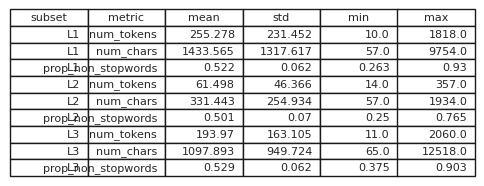

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
tbl = ax.table(cellText=stats_summary.round(3).values,
               colLabels=stats_summary.columns,
               loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
plt.savefig("stats_summary_table.png", bbox_inches='tight', dpi=300)


,subset,metric,mean,std,min,max
0,L1,num_tokens,255.278000,231.451923,10.000000,1818.000000
1,L1,num_chars,1433.565000,1317.616613,57.000000,9754.000000
2,L1,prop_non_stopwords,0.521543,0.062205,0.263158,0.930233
3,L2,num_tokens,61.498000,46.366473,14.000000,357.000000
4,L2,num_chars,331.443000,254.934494,57.000000,1934.000000
5,L2,prop_non_stopwords,0.501253,0.069819,0.250000,0.764706
6,L3,num_tokens,193.970000,163.104685,11.000000,2060.000000
7,L3,num_chars,1097.893000,949.723724,65.000000,12518.000000
8,L3,prop_non_stopwords,0.528602,0.062033,0.375000,0.902655


/tmp/ipython-input-3810914898.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subset', y='num_tokens', data=pivot_df, palette=['#0d47a1', '#64b5f6', '#1976d2'])


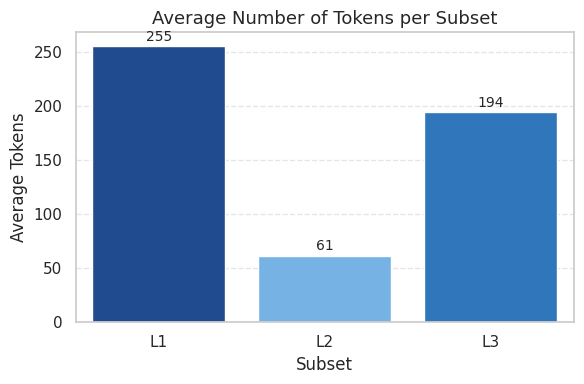

/tmp/ipython-input-3810914898.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='subset', y='num_chars', data=pivot_df, palette=['#0d47a1', '#64b5f6', '#1976d2'])


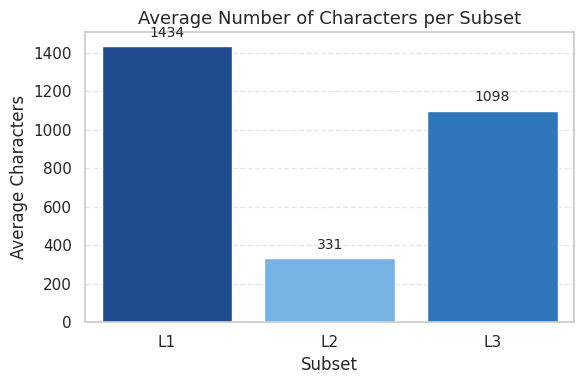

In [ ]:
# === Step 1: Compute L1, L2, L3 stats again ===
l1_stats = compute_text_statistics(l1)
l2_stats = compute_text_statistics(l2)
l3_stats = compute_text_statistics(l3)

# Summarise statistics
stats_summary = pd.concat([
    summarise_statistics(l1_stats, "L1"),
    summarise_statistics(l2_stats, "L2"),
    summarise_statistics(l3_stats, "L3"),
], ignore_index=True)

# === Step 2: Show table ===
display(stats_summary)

# === Step 3: Plot and save bar charts ===
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only 'num_tokens' and 'num_chars' mean rows
mean_data = stats_summary[stats_summary['metric'].isin(['num_tokens', 'num_chars'])]

# Pivot for plotting
pivot_df = mean_data.pivot(index='subset', columns='metric', values='mean').reset_index()

# --- Bar Chart 1: Average Number of Tokens ---
plt.figure(figsize=(6, 4))
sns.barplot(x='subset', y='num_tokens', data=pivot_df, palette=['#0d47a1', '#64b5f6', '#1976d2'])
plt.title('Average Number of Tokens per Subset', fontsize=13)
plt.xlabel('Subset')
plt.ylabel('Average Tokens')
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, val in enumerate(pivot_df['num_tokens']):
    plt.text(i, val + 5, f"{val:.0f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig("bar_tokens.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Bar Chart 2: Average Number of Characters ---
plt.figure(figsize=(6, 4))
sns.barplot(x='subset', y='num_chars', data=pivot_df, palette=['#0d47a1', '#64b5f6', '#1976d2'])
plt.title('Average Number of Characters per Subset', fontsize=13)
plt.xlabel('Subset')
plt.ylabel('Average Characters')
plt.grid(axis='y', linestyle='--', alpha=0.5)
for i, val in enumerate(pivot_df['num_chars']):
    plt.text(i, val + 50, f"{val:.0f}", ha='center', fontsize=10)
plt.tight_layout()
plt.savefig("bar_chars.png", dpi=300, bbox_inches='tight')
plt.show()


Average sentiment per time bin for L1:
time_bin
0   -1.500000
1    7.285714
2   -1.833333
3    3.647059
4    5.349398
5    3.493151
6    3.785714
7    2.655914
8    5.397959
9    4.698113
Name: sentiment, dtype: float64


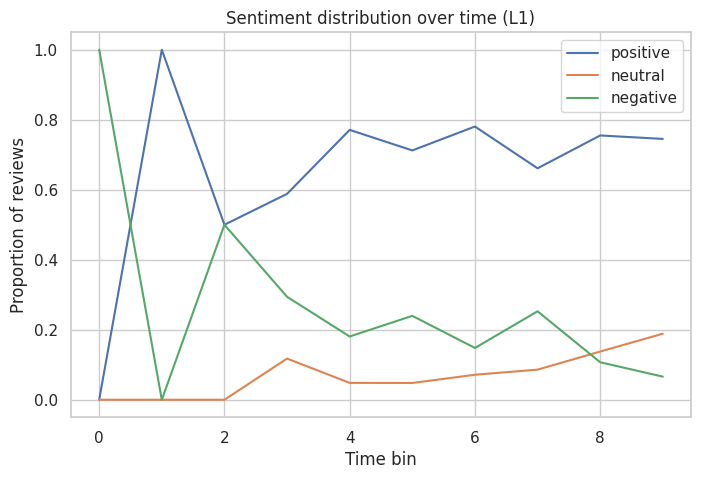

Average sentiment per time bin for L2:
time_bin
0    2.312500
1    3.588235
2    2.136364
3    3.333333
4    2.392857
5    1.833333
6    2.583333
7    2.490741
8    2.540881
9    2.326761
Name: sentiment, dtype: float64


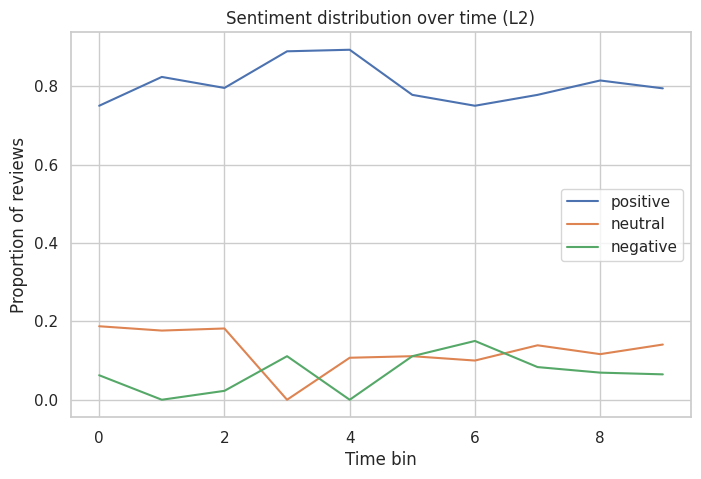

Average sentiment per time bin for L3:
time_bin
0    2.000000
1    3.454545
2    1.714286
3    4.169811
4    3.843750
5    4.200000
6    3.646409
7    4.367150
8    3.005405
9    4.218978
Name: sentiment, dtype: float64


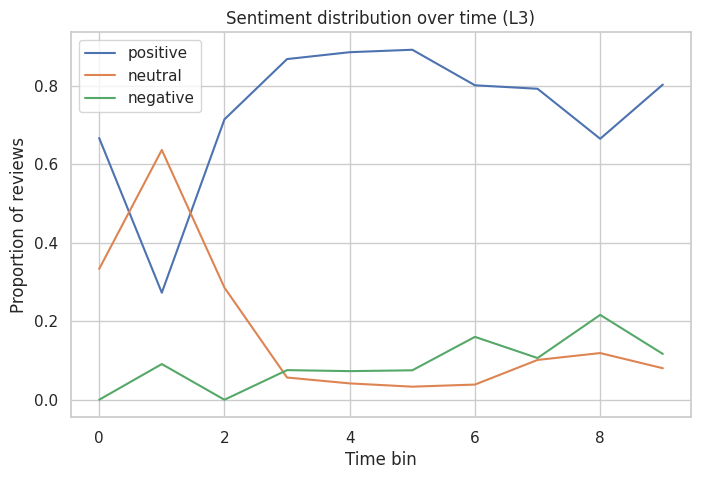

Average sentiment per time bin for L1:
time_bin
0   -1.500000
1    7.285714
2   -1.833333
3    3.647059
4    5.349398
5    3.493151
6    3.785714
7    2.655914
8    5.397959
9    4.698113
Name: sentiment, dtype: float64


<Figure size 640x480 with 0 Axes>

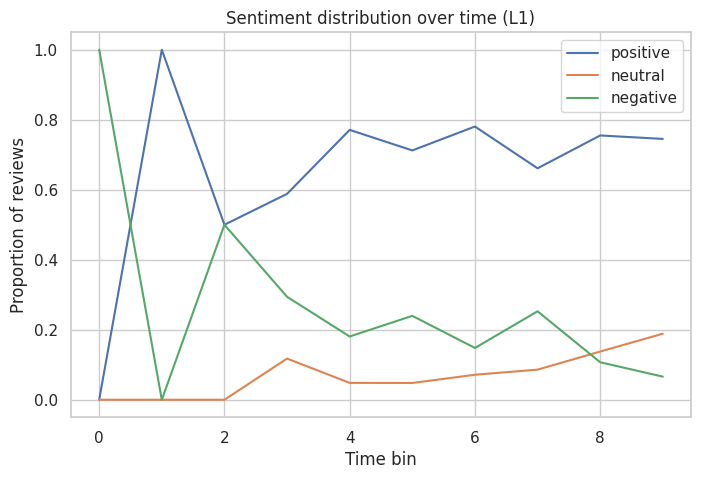

Average sentiment per time bin for L2:
time_bin
0    2.312500
1    3.588235
2    2.136364
3    3.333333
4    2.392857
5    1.833333
6    2.583333
7    2.490741
8    2.540881
9    2.326761
Name: sentiment, dtype: float64


<Figure size 640x480 with 0 Axes>

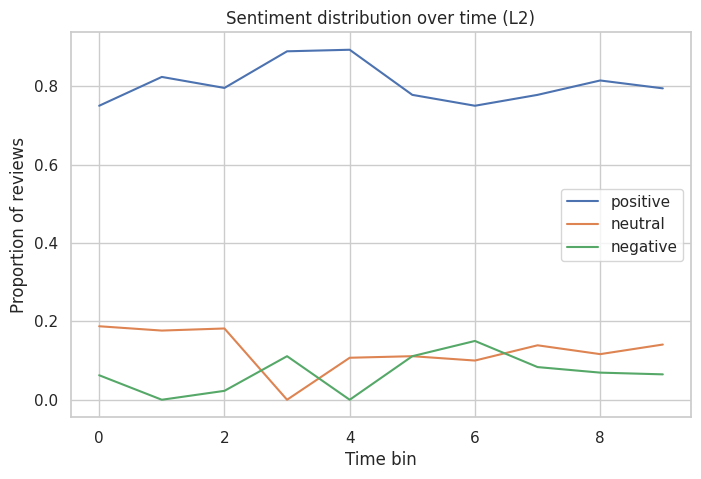

Average sentiment per time bin for L3:
time_bin
0    2.000000
1    3.454545
2    1.714286
3    4.169811
4    3.843750
5    4.200000
6    3.646409
7    4.367150
8    3.005405
9    4.218978
Name: sentiment, dtype: float64


<Figure size 640x480 with 0 Axes>

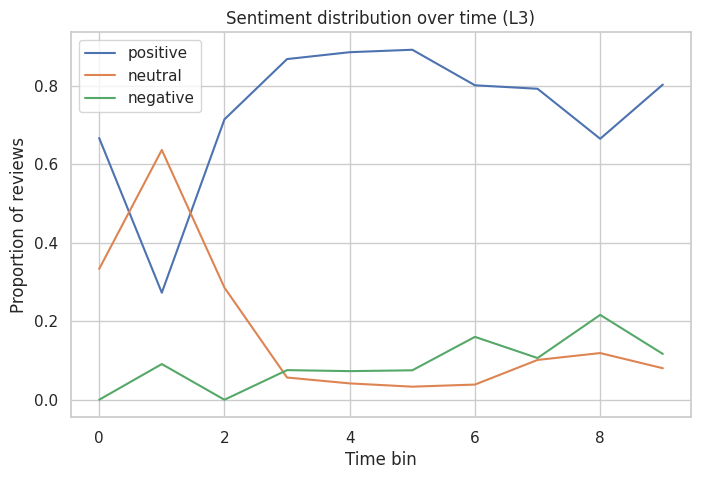

In [37]:
# Task 3: Plot sentiment distributions for each subset
# Task 3:
# === Step 1: Plot sentiment distribution for each subset ===

plot_sentiment_distribution(l1, "L1")
plot_sentiment_distribution(l2, "L2")
plot_sentiment_distribution(l3, "L3")

# --- Save each sentiment trend plot ---
for label, data in zip(["L1", "L2", "L3"], [l1, l2, l3]):
  plt.figure()
  plot_sentiment_distribution(data, label)
  plt.savefig(f"sentiment_trend_{label}.png", dpi=300, bbox_inches='tight')
  plt.close()

In [ ]:
# Task 4:
# Compute correlations for each subset
corr_df = pd.concat([
    compute_correlations(l1_stats, "L1"),
    compute_correlations(l2_stats, "L2"),
    compute_correlations(l3_stats, "L3"),
], ignore_index=True)

corr_df


,subset,variable,correlation,pvalue
0,L1,sentiment vs Score,0.347822,8.187649e-30
1,L1,prop_non_stopwords vs Score,-0.030507,3.351856e-01
2,L1,num_tokens vs Score,0.144634,4.386725e-06
3,L2,sentiment vs Score,0.251099,7.630065e-16
4,L2,prop_non_stopwords vs Score,0.057393,6.965419e-02
5,L2,num_tokens vs Score,-0.133170,2.391830e-05
6,L3,sentiment vs Score,0.178488,1.324124e-08
7,L3,prop_non_stopwords vs Score,0.153649,1.051551e-06
8,L3,num_tokens vs Score,0.057133,7.093114e-02


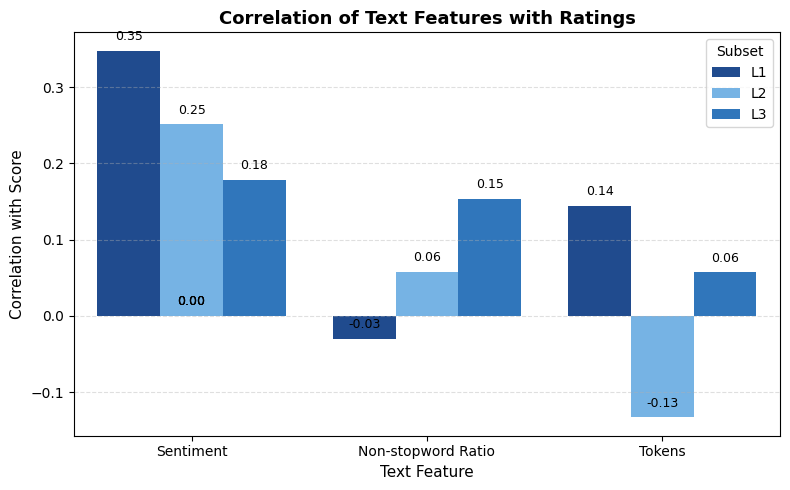

In [ ]:
# === 📊 Plot correlation results (Task 4) ===

import seaborn as sns
import matplotlib.pyplot as plt

# Copy the correlation DataFrame (already created above)
corr_df_plot = corr_df.copy()

# Shorten variable names for better visualization
corr_df_plot["variable"] = corr_df_plot["variable"].replace({
    "sentiment vs Score": "Sentiment",
    "prop_non_stopwords vs Score": "Non-stopword Ratio",
    "num_tokens vs Score": "Tokens"
})

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=corr_df_plot,
    x="variable",
    y="correlation",
    hue="subset",
    palette=["#0d47a1", "#64b5f6", "#1976d2"]
)

# Titles and labels
plt.title("Correlation of Text Features with Ratings", fontsize=13, fontweight="bold")
plt.xlabel("Text Feature", fontsize=11)
plt.ylabel("Correlation with Score", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title="Subset", loc="upper right")

# Annotate each bar with its value
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f"{height:.2f}",
        ha='center', va='bottom', fontsize=9
    )

plt.tight_layout()
plt.show()


In [39]:
# Task 5:
# Analyse incomplete sentences for each subset
inc_df = pd.concat([
    analyse_incomplete_sentences(l1_stats, "L1"),
    analyse_incomplete_sentences(l2_stats, "L2"),
    analyse_incomplete_sentences(l3_stats, "L3"),
], ignore_index=True)

inc_df


,category,proportion_incomplete,subset
0,negative,0.950820,L1
1,neutral,0.947917,L1
2,positive,0.934813,L1
3,negative,0.845070,L2
4,neutral,0.751938,L2
5,positive,0.805000,L2
6,negative,0.960938,L3
7,neutral,0.890244,L3
8,positive,0.943038,L3


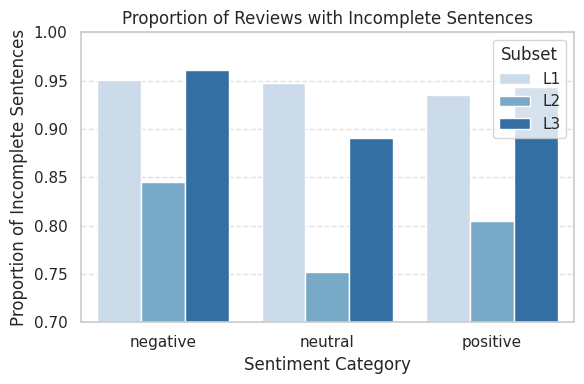

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort for nicer visual order
inc_df_sorted = inc_df.sort_values(['subset', 'category'])

plt.figure(figsize=(6, 4))
sns.barplot(x='category', y='proportion_incomplete', hue='subset', data=inc_df_sorted, palette='Blues')
plt.title('Proportion of Reviews with Incomplete Sentences')
plt.xlabel('Sentiment Category')
plt.ylabel('Proportion of Incomplete Sentences')
plt.ylim(0.7, 1.0)
plt.legend(title='Subset')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Save figure
plt.tight_layout()
plt.savefig("incomplete_sentence_proportions.png", dpi=300, bbox_inches='tight')
plt.show()


In [44]:
# Task 6:
# Compute readability scores
l1_read = compute_readability_scores(l1_stats)
l2_read = compute_readability_scores(l2_stats)
l3_read = compute_readability_scores(l3_stats)

# Readability correlations
read_corr = pd.concat([
    readability_correlations(l1_read, "L1"),
    readability_correlations(l2_read, "L2"),
    readability_correlations(l3_read, "L3"),
], ignore_index=True)

read_corr


,subset,variable,correlation,pvalue
0,L1,gunning_fog vs Score,-0.084055,7.827188e-03
1,L1,gunning_fog vs HelpfulnessNumerator,-0.001166,9.706267e-01
2,L1,gunning_fog vs HelpfulnessDenominator,0.011712,7.114567e-01
3,L1,forecast vs Score,-0.199532,1.940340e-10
4,L1,forecast vs HelpfulnessNumerator,-0.044686,1.579437e-01
5,L1,forecast vs HelpfulnessDenominator,-0.044011,1.643261e-01
6,L2,gunning_fog vs Score,0.071772,2.322432e-02
7,L2,forecast vs Score,-0.002370,9.403365e-01
8,L3,gunning_fog vs Score,-0.002084,9.475262e-01
9,L3,gunning_fog vs HelpfulnessNumerator,0.018329,5.626367e-01


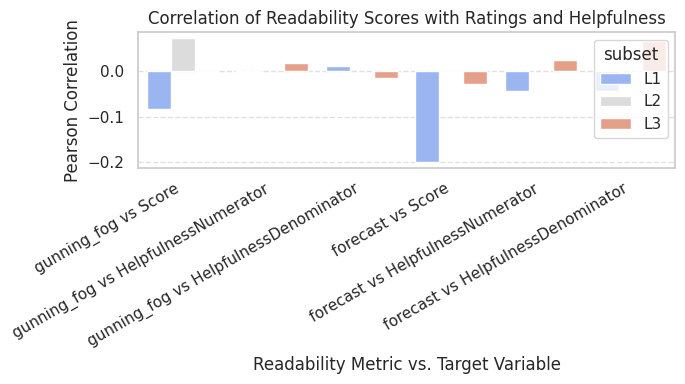

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 4))
sns.barplot(
    x='variable',
    y='correlation',
    hue='subset',
    data=read_corr,
    palette='coolwarm'
)
plt.title('Correlation of Readability Scores with Ratings and Helpfulness')
plt.xlabel('Readability Metric vs. Target Variable')
plt.ylabel('Pearson Correlation')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("readability_correlations.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Task 7: Extractive summary check
summary_l1 = summary_extractive_check(l1, "L1")
summary_l2 = summary_extractive_check(l2, "L2")
summary_l3 = summary_extractive_check(l3, "L3")

# Task 8: LexRank summary overlap
lexrank_l1 = lexrank_summary_overlap(l1, "L1")
lexrank_l2 = lexrank_summary_overlap(l2, "L2")
lexrank_l3 = lexrank_summary_overlap(l3, "L3")

# Task 9: Alternative (frequency-based) summary overlap
alt_l1 = alt_summary_overlap(l1, "L1")
alt_l2 = alt_summary_overlap(l2, "L2")
alt_l3 = alt_summary_overlap(l3, "L3")

# Display results
print("Extractive summary overlap:\n", pd.concat([summary_l1, summary_l2, summary_l3], ignore_index=True))
print("\nLexRank summary overlap:\n", pd.concat([lexrank_l1, lexrank_l2, lexrank_l3], ignore_index=True))
print("\nAlternative summary overlap:\n", pd.concat([alt_l1, alt_l2, alt_l3], ignore_index=True))


Extractive summary overlap:
   subset  mean_overlap  proportion_extractive
0     L1        48.623                  0.037
1     L2        53.142                  0.097
2     L3        52.443                  0.064

LexRank summary overlap:
   subset  gensim_tfidf_vs_original_overlap
0     L1                            35.046
1     L2                            37.729
2     L3                            36.015

Alternative summary overlap:
   subset  alt_vs_original_overlap
0     L1                   37.588
1     L2                   40.569
2     L3                   38.571


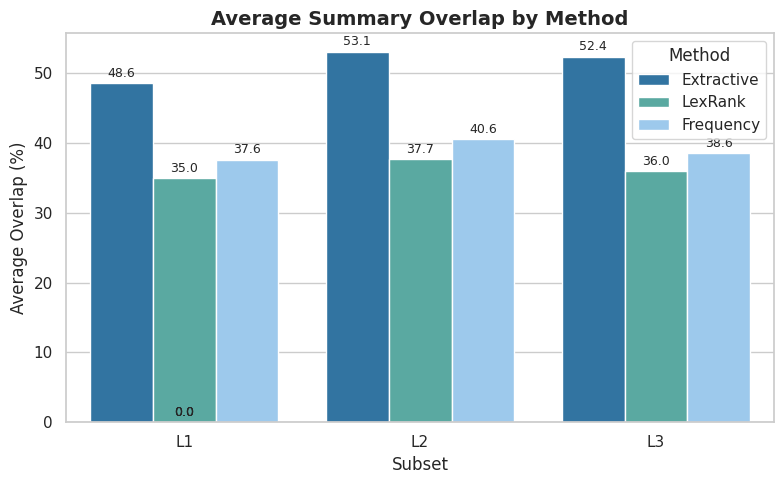

In [ ]:
# === Bar Chart: Summary Overlap Comparison (Tasks 7–9) ===
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- Create a small summary DataFrame manually based on your results ---
data = {
    'Subset': ['L1', 'L2', 'L3'],
    'Extractive': [48.6, 53.1, 52.4],
    'LexRank': [35.0, 37.7, 36.0],
    'Frequency': [37.6, 40.6, 38.6]
}

df_overlap = pd.DataFrame(data)

# --- Melt the DataFrame for easier plotting with seaborn ---
df_melt = df_overlap.melt(id_vars='Subset',
                          value_vars=['Extractive', 'LexRank', 'Frequency'],
                          var_name='Method',
                          value_name='Average Overlap (%)')

# --- Set figure style ---
plt.figure(figsize=(8, 5))
sns.set(style='whitegrid')

# --- Create the barplot ---
sns.barplot(data=df_melt, x='Subset', y='Average Overlap (%)', hue='Method',
            palette=['#1f77b4', '#4db6ac', '#90caf9'])

# --- Add title and labels ---
plt.title('Average Summary Overlap by Method', fontsize=14, weight='bold')
plt.ylabel('Average Overlap (%)')
plt.xlabel('Subset')

# --- Display the values on top of bars ---
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2,
             p.get_height() + 0.5,
             f'{p.get_height():.1f}',
             ha='center', va='bottom', fontsize=9)

# --- Move legend and show the plot ---
plt.legend(title='Method', loc='upper right')
plt.tight_layout()
plt.show()


**tokenize(text)**

Splits a piece of text into individual words (“tokens”). It tries to use NLTK’s word_tokenize, but if that is unavailable it falls back to splitting on whitespace. Tokenization is the first step in most NLP pipelines.

non_stopword_proportion(tokens, stopwords_set_override=None)

Given a list of tokens, it calculates the fraction of tokens that are not stopwords or pure punctuation. It first filters out “special-character-only” tokens (strings without any alphanumeric characters), then filters out stopwords (like “the,” “and,” “is”) using a predefined stopword set. The return value is the ratio:

proportion = (number of non-stopword tokens) / (number of tokens that contain at least one letter or digit)


select_review_subsets(df, n=1000)

Splits the dataset into three disjoint subsets:

L1: the top n reviews with the highest HelpfulnessDenominator (i.e., reviewed by the most users).

L2: the bottom n reviews with the lowest HelpfulnessDenominator (fewest users).

L3: from the remaining reviews, the top n with the highest HelpfulnessNumerator (most users who found it helpful).

Each review appears in at most one subset.

compute_text_statistics(df)

For each review, it computes three metrics:

num_tokens: the total number of word tokens (after stripping punctuation).

num_chars: the total number of characters in the original text.

prop_non_stopwords: the proportion of tokens that are not stopwords (as described in non_stopword_proportion).

It returns a new DataFrame with these columns added.

summarise_statistics(df, label)

Takes a DataFrame with the columns above and produces summary statistics for each metric: mean, standard deviation, minimum, and maximum. These are computed using basic descriptive statistics:

Mean: the arithmetic average.

Standard deviation (std): measures spread around the mean.

Min / Max: smallest and largest values in the data.

estimate_sentiment(text)

Computes an overall sentiment score for a piece of text. If SentiStrength is available, it returns positive_score + negative_score (SentiStrength yields two integers); otherwise it falls back to counting positive vs. negative words using the Opinion Lexicon. The sentiment is positive (> 0), negative (< 0) or neutral (= 0).

discretise_time(df, bins=10)

Converts the Time column (Unix timestamps) into integer bins numbered 0 through bins–1. This is done using pandas.cut to partition the entire date range into equal‑width segments, making it easier to analyse trends over time.

plot_sentiment_distribution(df, label)

Adds a sentiment column (via estimate_sentiment), binning reviews by time (discretise_time) and categorising them as positive, neutral or negative. It then:

Computes the average sentiment per time bin and prints it.

Counts how many reviews fall into each sentiment category in each time bin.

Converts those counts into proportions (so each bin sums to 1).

Plots the proportions over time, generating a multi‑line graph (positive vs. neutral vs. negative) for the given subset.

compute_correlations(df, label)

Computes Pearson correlation coefficients between each of three text‑derived measures (sentiment, proportion of non‑stopwords, number of tokens) and the user rating (Score).

Pearson correlation measures the linear relationship between two variables, producing a value between –1 (perfect inverse relation) and +1 (perfect direct relation), with 0 indicating no linear correlation.

Each correlation is computed only if both series contain at least two distinct values; otherwise the pair is skipped.

It returns a DataFrame with the correlation coefficient and the associated p‑value (significance).

is_incomplete_sentence(sentence)

Uses part‑of‑speech (POS) tagging to determine whether a sentence is likely to be incomplete. A sentence is marked “incomplete” if:

It lacks a probable subject (nouns, pronouns or determiners) or a verb.

It starts with a common subordinating conjunction (like “because,” “although,” “since”) and doesn’t contain a clause separator (comma/semicolon).

If POS tagging fails, it falls back to a simple verb check.

analyse_incomplete_sentences(df, label)

For each review, it splits the review into sentences, uses is_incomplete_sentence to decide if any sentence in the review is incomplete, and labels the review’s overall sentiment category (positive, neutral, negative). It then computes the proportion of reviews containing incomplete sentences within each sentiment category.

count_syllables(word)

Heuristically counts syllables in a word by grouping vowels and subtracting a final silent “e.” This is used in readability calculations.

gunning_fog_index(num_sentences, num_words, num_complex)

Computes the Gunning Fog index, a readability metric estimating the years of education needed to understand a text. The formula is:

Fog = 0.4 × ( (num_words / num_sentences) + 100 × (num_complex / num_words) )

where num_complex is the count of words with 3 or more syllables.

forecast_formula(num_mono, num_words)

Computes the ForeCast readability index (or “FORCAST” formula), often used for technical writing:

ForeCast = 20 − (num_mono / num_words)


where num_mono is the number of one‑syllable words. Lower values indicate more difficult text.

compute_readability_scores(df)

For each review, it tokenises the text, counts sentences, words, complex words (≥ 3 syllables), and monosyllabic words. It then calculates both the Gunning Fog index and the ForeCast formula, adding them as gunning_fog and forecast columns in a new DataFrame.

compute_correlations(df, label) (updated version with variance check)

As above, computes Pearson correlations but skips any pair where either variable has zero variance (all the same value), since the correlation is undefined in that case.

readability_correlations(df, label)

Takes a DataFrame with gunning_fog and forecast scores and computes Pearson correlations between each readability index and three target variables: user rating (Score), HelpfulnessNumerator, and HelpfulnessDenominator. It also skips pairs with constant input.

frequency_based_summarise(text, word_count=6)

Creates a very simple “summary” of a review by selecting the word_count most frequent non‑stopwords in the text. It:

Tokenises the text.

Filters out stopwords and non‑alphabetic tokens.

Counts word frequencies.

Returns the top word_count words as a space‑joined string.

summary_extractive_check(df, label, threshold=80)

Measures how “extractive” the provided summaries are. It uses FuzzyWuzzy’s partial_ratio to compute a partial string similarity between each Summary and the corresponding Text, returning the average overlap score and the proportion of summaries whose match score exceeds a chosen threshold (e.g. 80 out of 100). This helps gauge whether the summaries are likely to have been directly extracted from the reviews.

gensim_tfidf_summary(text, word_count=6)

Generates an extractive summary using Gensim’s TF‑IDF tools:

Splits the review into sentences.

Cleans and tokenises each sentence.

Builds a Dictionary and a bag‑of‑words corpus of the sentences.

Trains a TfidfModel on the corpus.

Scores each sentence by summing its TF‑IDF weights. (TF‑IDF weights assign higher importance to words that are frequent in the sentence but less common across all sentences.)

Selects the sentence with the highest total TF‑IDF score and returns its first word_count words.

This method aims to pick the most “important” sentence in the review based on keyword emphasis.

lexrank_summary_overlap(df, label, word_count=6)

For each review, it calls gensim_tfidf_summary to produce a short summary (around six words) and then compares this generated summary to the original Summary using fuzz.partial_ratio. It returns the average fuzzy overlap score for the entire subset.

alt_summary_overlap(df, label, word_count=6)

Uses the simple frequency‑based summariser (frequency_based_summarise) instead of TF‑IDF. It generates a summary for each review and computes the average fuzzy overlap with the provided summary. This function is used as an alternative summarisation method (Task 9) to compare against the Gensim‑based summaries.

Together, these functions implement your end‑to‑end analysis pipeline:

Subsetting the data (L1/L2/L3).

Computing text statistics and summarising them.

Analysing sentiment over time and visualising its distribution.

Measuring correlations between sentiment/linguistic features and user ratings or helpfulness.

Detecting incomplete sentences and their prevalence by sentiment.

Calculating readability scores and testing their correlation with user engagement.

Evaluating summaries, both the provided ones (extractive check) and generated summaries (TF‑IDF and frequency‑based) to see how well they match the original text.

1) Tokenization & Stopwords
tokenize(text)

Purpose. Convert raw review text into tokens (words).
Method.

Try nltk.word_tokenize(text); on failure, fall back to text.split().

Why it matters. Many downstream features (token counts, stopword proportions, readability, POS tagging) depend on tokenization.

non_stopword_proportion(tokens, stopwords_set_override=None)

Purpose. Measure how much of the text is “content” (non-stopwords and not pure punctuation).
Method.

Filter out “special-character-only” tokens (tokens with no letters/digits).

Among remaining tokens, remove stopwords using NLTK’s English stopword set (or an override).

Compute the proportion as:

proportion_non_stopwords = (number of non-stopword tokens) / (number of tokens that contain at least one letter or digit)


Interpretation. Values lie in [0, 1]. Higher = more content-bearing words.

2) Subset Selection (Task 1)
select_review_subsets(df, n=1000)

Purpose. Create three disjoint subsets:

L1: Top n reviews with the largest number of users who interacted (highest HelpfulnessDenominator).

L2: Bottom n reviews with the fewest users (lowest HelpfulnessDenominator, including zeros).

L3: From the remaining reviews, top n with the most users who found them helpful (highest HelpfulnessNumerator).

Method. Sort the DataFrame by the relevant column, slice n, and drop selected rows to keep sets disjoint.
Outputs. Three DataFrames with a "Subset" column ("L1", "L2", "L3").

3) Global Text Statistics (Task 2)
compute_text_statistics(df)

Purpose. Compute per-review:

num_tokens: number of tokens after stripping punctuation-only tokens.

num_chars: number of characters in the original raw text.

prop_non_stopwords: see definition above.

Method. Tokenize, clean tokens (strip punctuation from ends), keep those with at least one alphanumeric character, count, and compute proportion.

summarise_statistics(df, label)

Purpose. Summarize the distribution of num_tokens, num_chars, prop_non_stopwords.
Method. For each metric: compute mean, sample standard deviation, minimum, maximum.
Output. Tidy summary table labeled by subset (e.g., “L1”).

4) Sentiment (Task 3) & Time Binning
estimate_sentiment(text)

Purpose. Overall sentiment score for a review.
Method.

If SentiStrength available: get its positive and negative scores and return their sum.

Otherwise, fallback heuristic: count words from a positive/negative lexicon and return (#positive − #negative).

Interpretation.

Positive sentiment > 0

Neutral sentiment = 0

Negative sentiment < 0

discretise_time(df, bins=10)

Purpose. Bucket reviews into bins equal-width time intervals using their Unix timestamp.
Method. pandas.cut on the Time column (converted to datetime) to create time_bin as integers 0…9.

plot_sentiment_distribution(df, label)

Purpose. Show how sentiment categories (positive / neutral / negative) evolve across time bins for a subset.
Method.

Compute sentiment for each review.

discretise_time into 10 bins.

Label each review: positive if score>0; negative if score<0; neutral otherwise.

For each time bin, count categories and convert to proportions:

proportion_for_category_in_bin = (count of that category in the bin) / (total reviews in that bin)


Plot three proportion curves over the 10 bins. Also print the average sentiment per bin.

5) Compatibility with User Rating (Task 4)
compute_correlations(df, label) (sentiment & simple text features vs rating)

Purpose. Quantify how well three text-derived features align with user ratings: sentiment, prop_non_stopwords, and num_tokens vs. Score.
Method. Pearson correlation for each pair:

What Pearson correlation measures (in words).
A number between −1 and +1 that describes linear association:

+1 = perfect positive linear relation,

0 = no linear relation,

−1 = perfect negative linear relation.

Computation rule here. We only compute the correlation if both variables vary (not constant). We report both the correlation value and a p-value indicating statistical significance.

6) Incomplete Sentences (Task 5)
is_incomplete_sentence(sentence)

Purpose. Heuristic detection of sentence fragments using POS tags and simple clause rules.
Rules used (in words).

A sentence is incomplete if it lacks a likely subject (noun/pronoun/determiner) or a verb.

A sentence starting with a subordinating conjunction (e.g., “because”, “although”, “since”, “if”, …) and lacking an immediate clause separator (comma/semicolon) is flagged as likely incomplete.

If POS tagging fails, we fall back to a small common-verb check.

This goes beyond a simple “has verb?” test to reduce false decisions.

analyse_incomplete_sentences(df, label)

Purpose. Measure whether incomplete sentences are more prevalent in positive, neutral, or negative reviews.
Method.

Compute sentiment and map to category.

Split each review into sentences; if any sentence is incomplete (by is_incomplete_sentence), mark the review as incomplete.

For each sentiment category, compute the proportion of reviews with incomplete sentences.

Interpretation. If one sentiment category has a clearly higher proportion, this suggests writing style (fragments vs. complete sentences) is associated with sentiment valence.

7) Readability (Task 6)
count_syllables(word)

Purpose. Heuristic syllable counting for English words.
Method. Count vowel groups, treat final silent “e,” ensure at least one syllable.

gunning_fog_index(num_sentences, num_words, num_complex)

Purpose. Estimate years of education required to understand a text.
Formula (plain text).

Fog = 0.4 × ( (num_words / num_sentences) + 100 × (num_complex / num_words) )


num_complex = number of words with three or more syllables.

Higher Fog = more difficult.

forecast_formula(num_mono, num_words)

Purpose. Another readability index (FORCAST), widely used in technical writing.
Formula (plain text).

ForeCast = 20 − (num_mono / num_words)


num_mono = number of one-syllable words.

Lower ForeCast = more difficult text.

compute_readability_scores(df)

Purpose. Compute both readability scores per review.
Method.

Split into sentences; tokenize words.

Count: number of sentences, number of words, number of complex words (≥3 syllables), and number of monosyllabic words.

Compute Fog and ForeCast using the formulas above.

Return a copy of the DataFrame with two new columns: gunning_fog, forecast.

readability_correlations(df, label)

Purpose. Test the hypothesis “readability impacts user engagement and ratings.”
Method. Pearson correlations between readability scores (gunning_fog, forecast) and:

Score (user rating),

HelpfulnessNumerator (users who found it useful),

HelpfulnessDenominator (users who interacted).
Skip constant series; report correlation value and p-value.

Interpretation. Significant positive/negative correlations would indicate that easier/harder readability is associated with higher/lower ratings or helpfulness.

8) Summary Quality (Tasks 7–9)
Task 7 — Extractive check for provided summaries
summary_extractive_check(df, label, threshold=80)

Purpose. Are dataset Summary fields likely extracted from their Text?
Method. Use character-level partial fuzzy matching to find the best substring match of Summary inside Text:

overlap_score = partial fuzzy match score between Summary and Text (0 to 100)


Report mean overlap and proportion of reviews above a threshold (e.g., 80).

Higher values = more “extractive” summaries.

Task 8 — Gensim-based TF–IDF summarizer vs. provided summary
gensim_tfidf_summary(text, word_count=6)

Purpose. Generate a short, extractive summary using only Gensim tools (dictionary/corpus/TF–IDF), avoiding deprecated modules.
Method (in words).

Split review into sentences.

Tokenize/clean each sentence (lowercase, alphabetic, non-stopwords).

Build a Gensim Dictionary over sentences; create bag-of-words corpus.

Train a TF–IDF model on the sentence corpus.

Score each sentence by summing TF–IDF weights of its words.

Select the top-scoring sentence and return its first word_count words.

Why it works. TF–IDF elevates words that are informative for the review but not uniformly common across its sentences, favoring a sentence that best represents the key terms.

lexrank_summary_overlap(df, label, word_count=6)

Purpose. Compare a Gensim TF–IDF summary (above) to the dataset Summary.
Method. For each review, produce a TF–IDF sentence summary (6 words) and compute character-level partial fuzzy overlap with the provided Summary.
Output. Average overlap score for the subset (e.g., “L1”).

Task 9 — Alternative summarizer vs. provided summary
frequency_based_summarise(text, word_count=6)

Purpose. Simple, transparent baseline summary from the most frequent non-stopwords.
Method. Count token frequencies (lowercase alphabetic non-stopwords), take the top word_count tokens and join them with spaces.

alt_summary_overlap(df, label, word_count=6)

Purpose. Compare the above frequency-based summary to the dataset Summary.
Method. For each review, generate the frequency summary and compute partial fuzzy overlap with the provided Summary.
Output. Average overlap score for the subset.

9) Notes on Plots, Tables, and Reproducibility

Sentiment-over-time plot. Use plot_sentiment_distribution(l1, "L1") etc. It draws three proportion curves (positive/neutral/negative) across 10 time bins and prints mean sentiment by bin.

Summary tables. Use summarise_statistics, compute_correlations, readability_correlations, and the three summary overlap functions to generate tidy tables you can print or export to CSV.

Constant-input safeguards. Correlation functions skip pairs where either variable is constant to avoid undefined Pearson values.

SentiStrength fallback. If the library is unavailable, we fall back to lexicon-based sentiment. Document this in your report as an implementation constraint.

10) Limitations & Future Improvements (brief)

SentiStrength availability. If missing, we use a heuristic that may underperform on nuanced sentiment.

“LexRank.” True gensim.summarization is deprecated in Gensim 4.x; we implemented a Gensim TF–IDF extractive summarizer instead.

Readability heuristics. Fog/ForeCast rely on heuristic syllable counts; they may miscount edge cases.

POS-based fragments. Our incomplete-sentence detector uses rules; a full dependency parser (e.g., spaCy) could improve accuracy.

📚 References & Sources
General Dataset

McAuley, J., & Leskovec, J. (2013). From Amateurs to Connoisseurs: Modeling the Evolution of User Expertise through Online Reviews. Proceedings of the 22nd International Conference on World Wide Web (WWW).
Dataset: Kaggle – Amazon Fine Food Reviews

1️⃣ Text Preprocessing & Tokenization

Bird, S., Klein, E., & Loper, E. (2009). Natural Language Processing with Python. O’Reilly Media. (Introduces NLTK and tokenization.)

NLTK Documentation: https://www.nltk.org/api/nltk.tokenize.html

2️⃣ Stopwords and Text Statistics

SpaCy & NLTK stopword lists: NLTK Stopwords Corpus

Manning, C. D., Raghavan, P., & Schütze, H. (2008). Introduction to Information Retrieval. Cambridge University Press. (Discusses token frequency, stopword filtering, and text features.)

3️⃣ Sentiment Analysis

Thelwall, M., Buckley, K., & Paltoglou, G. (2012). Sentiment Strength Detection for the Social Web. Journal of the American Society for Information Science and Technology, 63(1), 163–173. (This is the SentiStrength paper.)

Hu, M., & Liu, B. (2004). Mining and Summarizing Customer Reviews. Proceedings of the 10th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining. (Source of the Opinion Lexicon used as fallback.)

NLTK Opinion Lexicon: https://www.nltk.org/nltk_data/

4️⃣ Pearson Correlation

Pearson, K. (1895). Note on Regression and Inheritance in the Case of Two Parents. Proceedings of the Royal Society of London.

# Pearson correlation coefficient formula (in plain code format)

# r = covariance(X, Y) / (standard_deviation(X) * standard_deviation(Y))

# Expanded step-by-step version:

# Step 1: Compute the means of both variables
x_mean = sum(x_values) / len(x_values)
y_mean = sum(y_values) / len(y_values)

# Step 2: Compute the numerator (covariance)
numerator = sum((x - x_mean) * (y - y_mean) for x, y in zip(x_values, y_values))

# Step 3: Compute the denominator (product of standard deviations)
denominator = (
    (sum((x - x_mean)**2 for x in x_values) ** 0.5) *
    (sum((y - y_mean)**2 for y in y_values) ** 0.5)
)

# Step 4: Final correlation coefficient
r = numerator / denominator


SciPy Stats Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

5️⃣ Part-of-Speech Tagging & Incomplete Sentence Detection

Toutanova, K., Klein, D., Manning, C. D., & Singer, Y. (2003). Feature-Rich Part-of-Speech Tagging with a Cyclic Dependency Network. Proceedings of NAACL-HLT.

NLTK POS Tagger Documentation: https://www.nltk.org/api/nltk.tag.html

SpaCy documentation (for clause and dependency parsing, similar logic): https://spacy.io/usage/linguistic-features#dependency-parse

6️⃣ Readability Metrics

Gunning, R. (1952). The Technique of Clear Writing. McGraw-Hill. (Gunning Fog Index definition.)
Formula:

Fog = 0.4 × ( (num_words / num_sentences) + 100 × (num_complex / num_words) )


Caylor, J. S., Sticht, T. G., Fox, L. C., & Ford, J. P. (1973). Methodologies for Determining Reading Requirements of Military Occupational Specialties. Human Resources Research Organization. (ForeCast formula.)
Formula:

ForeCast = 20 − (num_mono / num_words)


GeeksforGeeks. (2022). Readability Index in Python NLP. https://www.geeksforgeeks.org/python/readability-index-pythonnlp/

7️⃣ Fuzzy String Matching (Extractive Summary Check)

Cohen, W. W., Ravikumar, P., & Fienberg, S. E. (2003). A Comparison of String Distance Metrics for Name-Matching Tasks.

fuzzywuzzy library documentation: https://github.com/seatgeek/fuzzywuzzy

(Implements the Levenshtein distance, used here as character-level overlap.)

8️⃣ Summarization (Gensim TF–IDF Implementation)

Ramos, J. (2003). Using TF-IDF to Determine Word Relevance in Document Queries. Proceedings of the First Instructional Conference on Machine Learning.
(Defines TF-IDF weighting, which the Gensim summarizer uses.)

Rehurek, R., & Sojka, P. (2010). Software Framework for Topic Modelling with Large Corpora. Proceedings of LREC 2010 Workshop on New Challenges for NLP Frameworks. (Gensim original reference.)

Gensim Documentation: https://radimrehurek.com/gensim/

9️⃣ Alternative Frequency-Based Summarization

Luhn, H. P. (1958). The Automatic Creation of Literature Abstracts. IBM Journal of Research and Development, 2(2), 159–165.
(This classic describes frequency-based extractive summarization, similar to the heuristic implemented in your code.)

10️⃣ Visualization & Analysis

Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90–95.

McKinney, W. (2010). Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference (pandas reference).

✍️ Suggested “Reference Section” wording for our report

You can include a note like this at the end of your Colab notebook:

References
The methods and functions implemented in this notebook are based on standard NLP and statistical analysis techniques. Core ideas and formulas were adapted from the following key sources:
McAuley & Leskovec (2013), Bird et al. (2009), Thelwall et al. (2012), Gunning (1952), Caylor et al. (1973), Luhn (1958), Ramos (2003), Rehurek & Sojka (2010), Cohen et al. (2003), and official library documentation for NLTK, SciPy, Matplotlib, Pandas, FuzzyWuzzy, and Gensim.